# 4. Decision Trees

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
import pydotplus
from sklearn import tree
from sklearn.metrics import r2_score
import seaborn as sns
import pickle as pkl
import math
import matplotlib.pyplot as plt
import time
import platform
import random
import os



The Wisconsin Breast Cancer Dataset(WBCD) can be found here(https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data)

This dataset describes the characteristics of the cell nuclei of various patients with and without breast cancer. The task is to classify a decision tree to predict if a patient has a benign or a malignant tumour based on these features.

Attribute Information:
```
#  Attribute                     Domain
   -- -----------------------------------------
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
  10. Mitoses                       1 - 10
  11. Class:                        (2 for benign, 4 for malignant)
```


In [ ]:
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.data', na_values='?',    
         header=None, index_col=['ID'], names = headers) 
data = data.reset_index(drop=True)
data = data.fillna(0)
data.head()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2


In [ ]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

## Q1. (a) 
####Implement a decision tree(from scratch using only python data structures) as a class.

In [ ]:
class TreeNode:

     def __init__(self):
        self.giniscore = 1
        self.entropy = 1
        self.ypredict = 2
        self.feature = 0
        self.threshold = 0
        self.left = None
        self.right = None

## Q1. (b) 
####Train a decision tree object of the above class on the WBC dataset using misclassification rate, entropy and Gini as the splitting metrics.

In [ ]:
class DecisionTree:

    maxDepth = 0
    root = None
    num_of_features = 0
    metrics = ""

    def __init__(self, maxDepth, metrics):
        self.maxDepth = maxDepth
        self.metrics = metrics

    #----------------------------------------------------------------------------#

    def entropy(self, nodes, total):
        if total==0:
            return 0.0
        a = float (nodes[0]/float (total))
        b = float (nodes[1]/float (total))
        if a==0 or b==0:
            return 0.0
        return  -1 * (a*math.log2(a) + b*math.log2(b))  

    #----------------------------------------------------------------------------#

    def gini(self, nodes, total):
        if total==0:
            return 0.0
        else:
            return (1.0 - ((float (nodes[0])/float (total))**2) - ((float (nodes[1])/float (total))**2))

    #----------------------------------------------------------------------------#

    def best_split(self, x, y):

        best_gini = 1
        best_entropy = 1
        best_feature = -1
        best_threshold = 0

        for col_idx in range (self.num_of_features):
            
            tempx = []
            for i in range(len(x)):
                t = []
                t.append(x[i][col_idx])
                t.append(y[i])
                tempx.append(t)
            
            tempx.sort(key=lambda x:x[0])

            m = len(tempx) # no. of training  samples

            if m <= 1:
                return None, None

            # Total samples of class A & B in parent Node
            countA = 0
            countB = 0
            for i in range(m):
                if tempx[i][1]==2:
                    countA+=1;
                else:
                    countB+=1;

            left = [0,0]
            right = [countA, countB]

            idx = 0
            while (idx<m):
                
                threshold = tempx[idx][0]

                while (idx<m and threshold == tempx[idx][0]):
                    if tempx[idx][1] == 2:
                        left[0]+=1
                        right[0]-=1
                    else:
                        left[1]+=1
                        right[1]-=1
                    idx+=1
                
                if self.metrics == "gini":
                    left_gini = self.gini(left, idx)
                    right_gini = self.gini(right, m-idx)
                    avg_gini = (idx*left_gini + (m-idx)*right_gini) / float (m)

                    if avg_gini < best_gini:
                        best_gini = avg_gini
                        best_feature = col_idx
                        best_threshold = threshold
                
                elif self.metrics == "entropy":
                    left_entropy = self.entropy(left, idx)
                    right_entropy = self.entropy(right, m-idx)
                    avg_entopy = (idx*left_entropy + (m-idx)*right_entropy) / float (m)

                    if avg_entopy < best_entropy:
                        best_entropy = avg_entopy
                        best_feature = col_idx
                        best_threshold = threshold 

        return best_feature, best_threshold

    #----------------------------------------------------------------------------#

    def predict_class(self, countA, countB):
        if countA>countB:
            return 2
        else:
            return 4  

    #----------------------------------------------------------------------------#

    def build_tree(self,x,y,depth):
        treenode = TreeNode()

        countA = 0
        countB = 0
        for val in y:
            if val==2:
                countA+=1;
            else:
                countB+=1;
        count = []
        count.append(countA)
        count.append(countB)

        ginis = self.gini(count, countA+countB)
        entp = self.entropy(count, countA+countB)
        treenode.giniscore = ginis
        treenode.entropy = entp

        treenode.ypredict = self.predict_class(countA, countB)

        if ginis == 0.0:
            return treenode

        if entp == 0.0:
            return treenode 
  
        if depth < self.maxDepth:

            best_feature, best_threshold = self.best_split(x,y)
            if best_feature == None:
                return treenode
            
            treenode.feature = best_feature
            treenode.threshold = best_threshold
            #print(best_feature, best_threshold)
            cutoff = x[:, best_feature] <= best_threshold
            leftA,leftB = x[cutoff], y[cutoff]
            rightA,rightB = x[~cutoff], y[~cutoff]

            treenode.left = self.build_tree(leftA, leftB, depth + 1)
            treenode.right = self.build_tree(rightA, rightB, depth + 1)

        return treenode

    #----------------------------------------------------------------------------#

    def fit(self, x, y):
        self.num_of_features = len(x[0])
        self.root = self.build_tree(x,y,0)

    #----------------------------------------------------------------------------#

    def predict(self, xtest):
        res = []
        for row in xtest:
            res.append(self.predict_helper(row))
        return res

    #----------------------------------------------------------------------------#

    def predict_helper(self, row):
        node = self.root
        while node:
            if node.left==None:
                return node.ypredict
            if int(row[node.feature]) <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.ypredict

    #----------------------------------------------------------------------------#

    def get_DFS(self,treenode,tab_space):
 
        if treenode.left == None and treenode.right==None:
            return tab_space + str(treenode.ypredict)
    
        statement = tab_space + 'IS ' + headers[treenode.feature] + '?\n'
        new_tab = tab_space + ' '

        if treenode.left:
            statement += tab_space + 'True Branch\n'
            statement += self.get_DFS(treenode.left,new_tab)

        if treenode.right:
            statement += tab_space + 'False Branch\n'
            statement += self.get_DFS(treenode.right,new_tab)

        return statement
 
    #----------------------------------------------------------------------------#

    def DFS(self):
        tab_space=''
        statement = self.get_DFS(self.root,tab_space)
        opfile = open("outputimp.txt", "w")
        opfile.write(statement)
        opfile.close()
        print(statement)


## Q1. (c) 
####Report the accuracies in each of the above splitting metrics and give the best result. 

In [ ]:
tree1 = DecisionTree(5, 'entropy')
tree1.fit(x_train, y_train)
y_predict1 = tree1.predict(x_test)

tree2 = DecisionTree(5, 'gini')
tree2.fit(x_train, y_train)
y_predict2 = tree2.predict(x_test)

print("\nAccuracy for various splitting metrics")
print("--------------------------------------")
print()
crrct = 0
for i in range(len(y_test)):
    if (y_predict1[i]==y_test[i]):
        crrct+=1
accuracy = float(crrct) / len(x_test)
print('Entropy : %d / %d correct => accuracy: %f' % (crrct, len(x_test), accuracy))

crrct = 0
for i in range(len(y_test)):
    if (y_predict2[i]==y_test[i]):
        crrct+=1
accuracy = float(crrct) / len(x_test)
print('Gini :  %d / %d correct => accuracy: %f' % (crrct, len(x_test), accuracy))



Accuracy for various splitting metrics
--------------------------------------

Entropy : 133 / 140 correct => accuracy: 0.950000
Gini :  134 / 140 correct => accuracy: 0.957143


## Q1. (d) 
Experiment with different approaches to decide when to terminate the tree(number of layers, purity measure, etc). Report and give explanations for all approaches. 

I used following two approaches to control the growth of the tree : 

1. I provided maxDepth as a parameter while creating an object of decision tree classifier.

2. I used gini index and entopy for pruning. Whenever gini score or entopy becomes zero on any node, i stopped splitting that node further.

## Q1. (e) 
####Does standardisation and normalisation help in this case? Report

Decision trees and ensemble methods do not require feature scaling to be performed as they are not sensitive to the the variance in the data.

## Q2. 
####Compare your trained model with a model trained by the scikit-learn DecisionTreeClassifier module. Compare accuracies.


In [ ]:
dt = tree.DecisionTreeClassifier(max_depth=4)
dt.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tpred = dt.predict(x_test)

print("\nAccuracy for scikit learn")
print("--------------------------------------")
print()
crrct = 0
for i in range(len(y_test)):
    if (tpred[i]==y_test[i]):
        crrct+=1
accuracy = float(crrct) / len(x_test)
print('%d / %d correct => accuracy: %f' % (crrct, len(x_test), accuracy))


Accuracy for scikit learn
--------------------------------------

130 / 140 correct => accuracy: 0.928571


## Q3. 
####Output a depth first traversal of your decision tree in a file named ```outputimp.txt``` respectively in the following format and submit it along with the assignment.

In [ ]:
tree2.DFS()

IS UCSize?
True Branch
 IS SECSize?
 True Branch
  IS BC?
  True Branch
   IS MA?
   True Branch
    IS SECSize?
    True Branch
     2    False Branch
     2   False Branch
    IS ID?
    True Branch
     2    False Branch
     4  False Branch
   IS ID?
   True Branch
    2   False Branch
    4 False Branch
  IS BN?
  True Branch
   IS UCShape?
   True Branch
    4   False Branch
    2  False Branch
   4False Branch
 IS SECSize?
 True Branch
  IS ID?
  True Branch
   IS UCShape?
   True Branch
    2   False Branch
    IS SECSize?
    True Branch
     2    False Branch
     4  False Branch
   IS MA?
   True Branch
    IS UCShape?
    True Branch
     4    False Branch
     2   False Branch
    4 False Branch
  IS UCSize?
  True Branch
   IS ID?
   True Branch
    IS BC?
    True Branch
     2    False Branch
     4   False Branch
    IS BN?
    True Branch
     4    False Branch
     4  False Branch
   IS UCShape?
   True Branch
    IS ID?
    True Branch
     4    False Branch
     4 

Sklearn Tree Structure



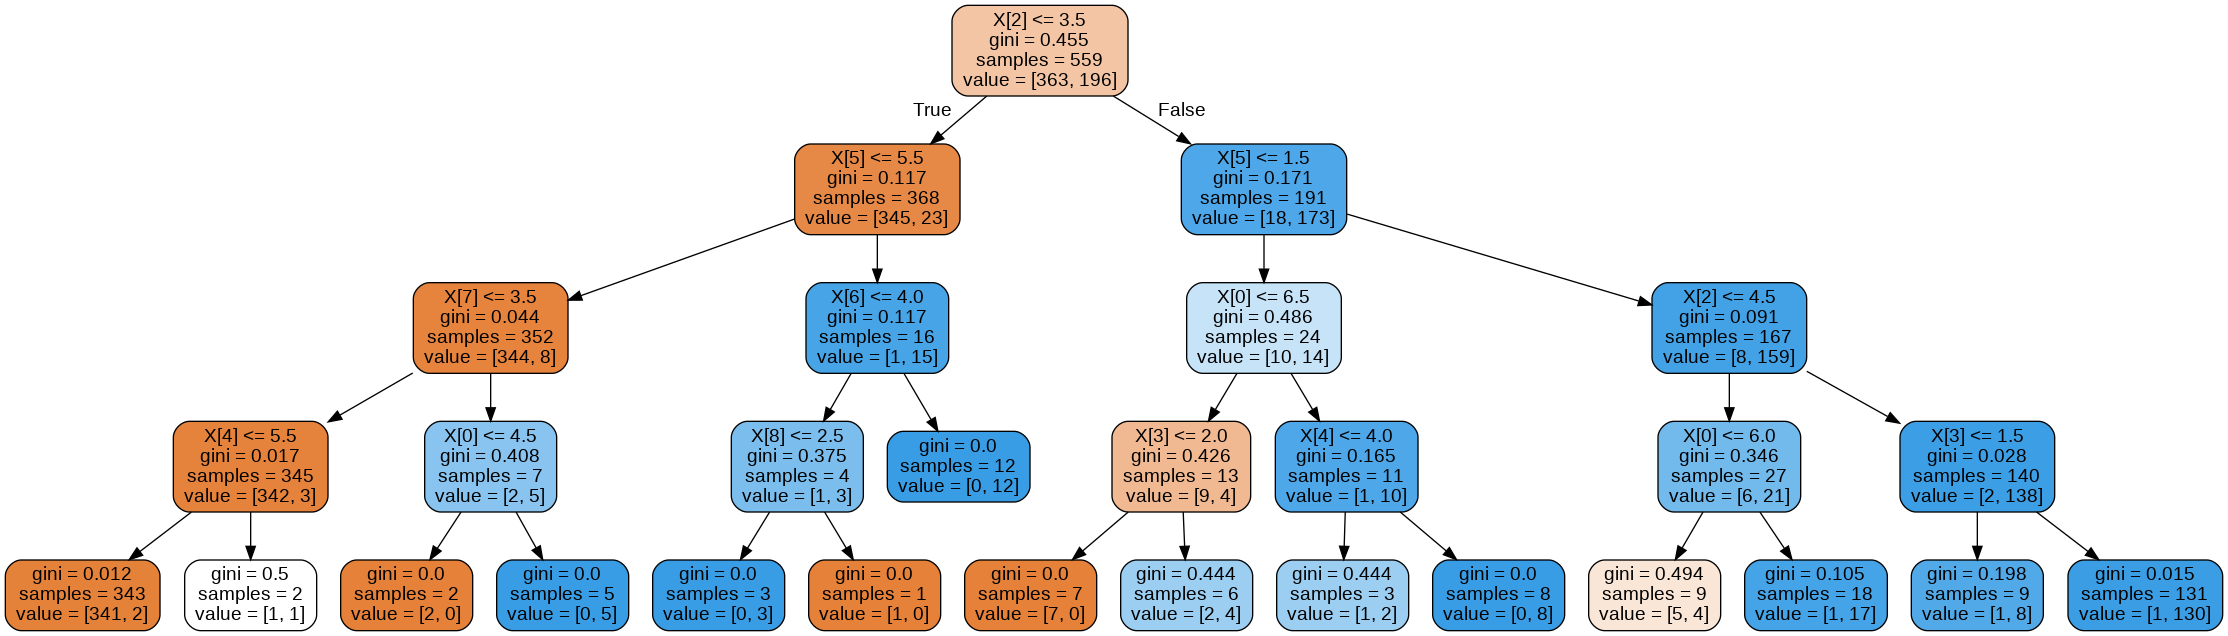

In [ ]:
print("Sklearn Tree Structure")
print()
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Q4. 
####Experiment with removing features that are redundant, highly correlated with other features and report accuracies of the resulting model. Explain your approach.

As we can clearly see from the below heatmap that UCSize and SECSize are highly correlated with UCSize hence they are redundant features so i removed them. My accuracy increases after feature seletion.

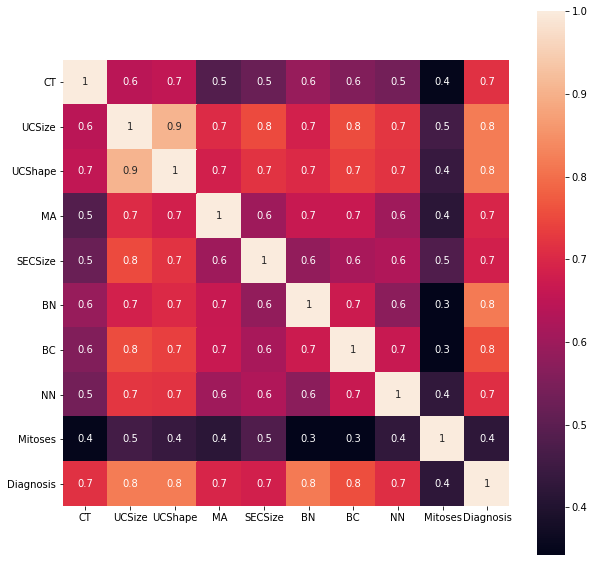

In [ ]:
data1 = data
fig, ax = plt.subplots(figsize=(10,10))
cor = data1.corr() 
sns.heatmap(cor, annot = True, fmt='.1g', ax=ax, square=True)

In [ ]:
def tree_feature_selection(df, cols):
    for c in cols:
        df = df.drop(c,1)
    return df

rem_features1 = ['UCSize','SECSize']
data1 = tree_feature_selection(data1, rem_features1)

x1 = data1.iloc[:, :-1]
y1 = data1.iloc[:, -1:]
print(x1.shape)
print(y1.shape)
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

x1_train = np.array(x1_train)
y1_train = np.array(y1_train)
x1_test = np.array(x1_test)
y1_test = np.array(y1_test)

(699, 7)
(699, 1)


In [ ]:
tree1 = DecisionTree(5, 'entropy')
tree1.fit(x1_train, y1_train)
y_predict1 = tree1.predict(x1_test)

tree2 = DecisionTree(5, 'gini')
tree2.fit(x1_train, y1_train)
y_predict2 = tree2.predict(x1_test)

print("\nAccuracy for various splitting metrics for UNNORMALIZED DATA")
print("--------------------------------------")
print()
crrct = 0
for i in range(len(y1_test)):
    if (y_predict1[i]==y1_test[i]):
        crrct+=1
accuracy = float(crrct) / len(x1_test)
print('Entropy : %d / %d correct => accuracy: %f' % (crrct, len(x1_test), accuracy))

crrct = 0
for i in range(len(y1_test)):
    if (y_predict2[i]==y1_test[i]):
        crrct+=1
accuracy = float(crrct) / len(x1_test)
print('Gini :  %d / %d correct => accuracy: %f' % (crrct, len(x1_test), accuracy))



Accuracy for various splitting metrics for UNNORMALIZED DATA
--------------------------------------

Entropy : 134 / 140 correct => accuracy: 0.957143
Gini :  135 / 140 correct => accuracy: 0.964286


## Q5.
#### Report the advantages and disadvantages of decision trees

Advantages :

1. Less data cleansing required.
2. Feature selection does not required.
3. It is a non parametric method.
4. It implicitly perform variable screening or feature selection.

Disadvantages :
1. Decision trees are prone to overfitting.
2. Pruning is required to prevent overfitting.
3. Not fit for continous variables.
4. Decision tree can become unstable because of small variations.




---



